In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from covidxpert import load_image, perspective_correction
from covidxpert.perspective_correction.add_padding import add_padding
from scipy.signal import find_peaks

In [2]:
def get_kernel_size(image:np.ndarray)->int:
    kernel_size = int(min(image.shape) / 5)
    
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    return kernel_size

In [3]:
def apply_mean_blur(image:np.ndarray)->np.ndarray:
    return cv2.medianBlur(image, get_kernel_size(image))

In [4]:
def apply_median_threshold(image:np.ndarray)->np.ndarray:
    return cv2.threshold(image, np.median(image)/2, 255, cv2.THRESH_BINARY)[1]

In [5]:
def trim_padding(image:np.ndarray, padding:int)->np.ndarray:
    return image[padding:-padding, padding:-padding]

In [6]:
def count_from_left_side(mask:np.ndarray):
    counter = 0
    for boolean in mask:
        if boolean:
            counter += 1
        else:
            break
    return counter

In [7]:
def count_from_right_side(mask:np.ndarray):
    return count_from_left_side(np.flip(mask, axis=0))

In [8]:
def build_slice(left:int, right:int, maximum:int):
    return slice(left, maximum if right==0 else right)

In [9]:
def strip_black(image:np.ndarray, mask:np.ndarray, v_threshold:float, h_threshold:float)->np.ndarray:
    vertical_mask = mask.mean(axis=1) < v_threshold
    horizzontal_mask = mask.mean(axis=0) < h_threshold
    
    h_slice = build_slice(
        count_from_left_side(horizzontal_mask),
        -count_from_right_side(horizzontal_mask),
        image.shape[1]
    )
    v_slice = build_slice(
        count_from_left_side(vertical_mask),
        -count_from_right_side(vertical_mask),
        image.shape[0]
    )
    return image[v_slice, h_slice]

In [10]:
def compute_median_threshold(mask:np.ndarray)->float:
    masked_mask = strip_black(mask, mask, 0, 0)
    v_white_median = np.median(mask.mean(axis=0))
    h_white_median = np.median(mask.mean(axis=1))
    return v_white_median/2, h_white_median/2

In [18]:
def remove_artefacts(image:np.ndarray, sigma_1:float=1, sigma_2:float=5)->np.ndarray:
    blur1 = cv2.GaussianBlur(image, (5,5), sigma_1, sigma_1).astype(float)
    blur2 = cv2.GaussianBlur(image, (5,5), sigma_2, sigma_2).astype(float)
    result = blur1 - blur2
    result = np.uint8(((result - result.min()) / (result.max() - result.min()))*255)
    result = cv2.threshold(image, np.median(result), 255, cv2.THRESH_BINARY)[1]
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(result, connectivity=8)
    sizes = stats[1:, -1]
    area = sizes.max()
    artefacts = np.zeros(result.shape, dtype=bool)
    for i, size in enumerate(sizes):
        if size < area/20:
            artefacts |= output==i+1
    cleared_image = image.copy()
    cleared_image[artefacts]=0
    return cleared_image

In [19]:
def get_blur_mask(image:np.ndarray, padding:int):
    blurred = add_padding(image, padding)
    blurred = remove_artefacts(blurred)
    blurred = apply_mean_blur(blurred)
    blurred = apply_median_threshold(blurred)
    return trim_padding(blurred, padding)

In [20]:
def blur_bbox(image:np.ndarray, padding:int=50)->np.ndarray:
    mask = get_blur_mask(image, padding)
    return strip_black(image, mask, *compute_median_threshold(mask))

In [21]:
paths = glob("tests/test_images/*.jpg")

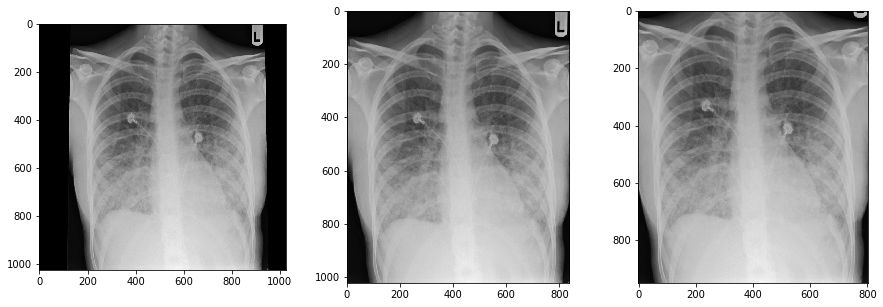

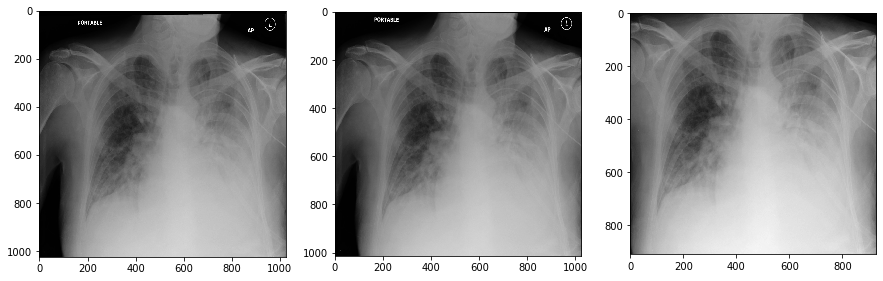

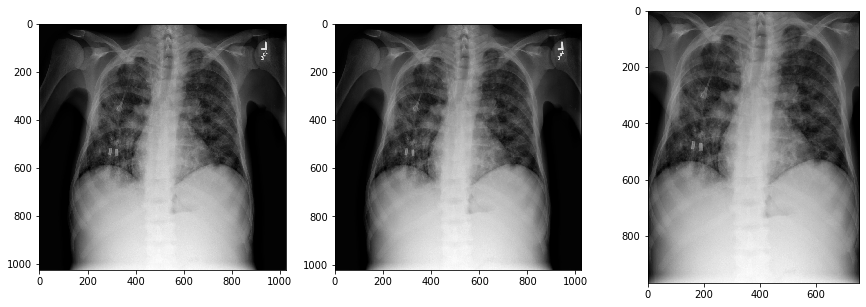

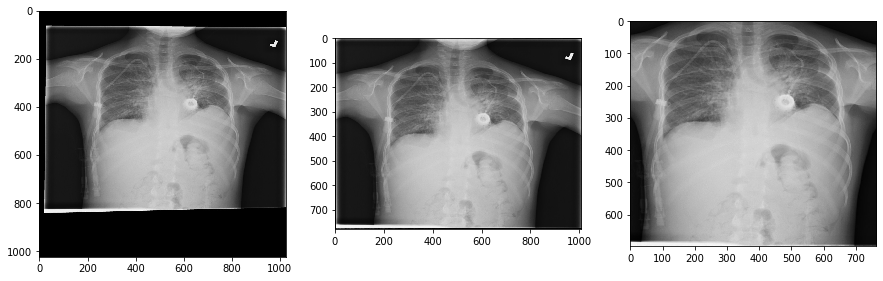

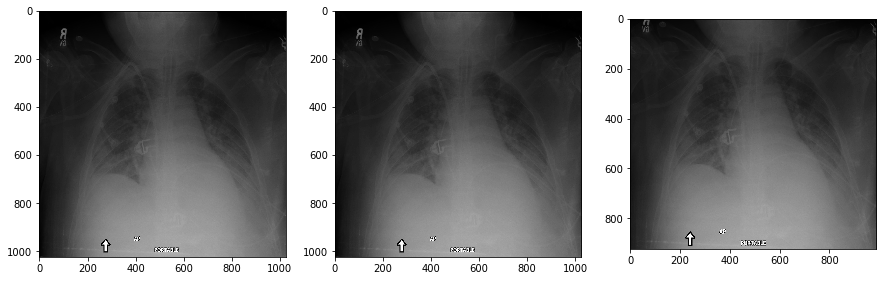

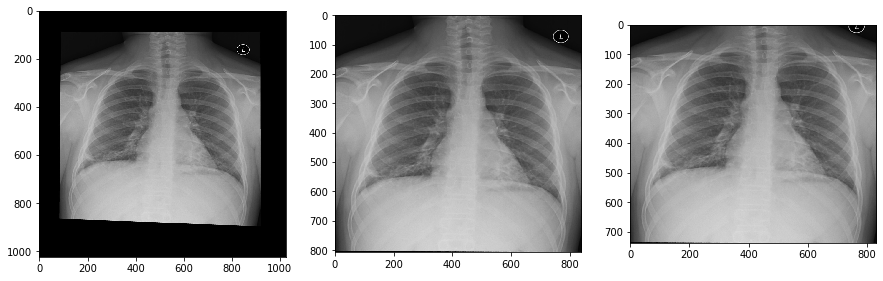

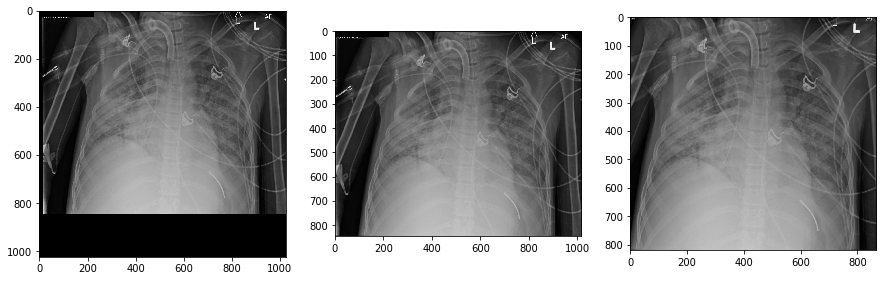

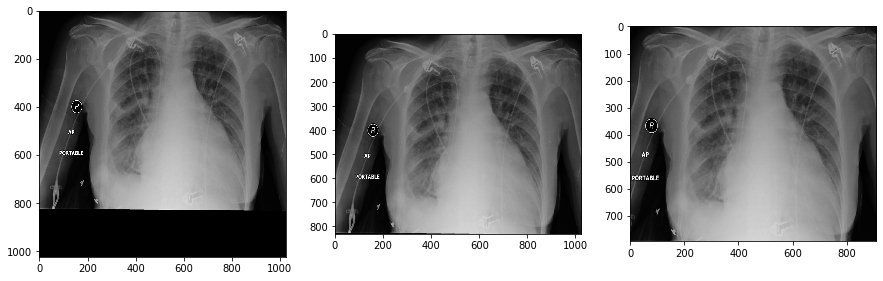

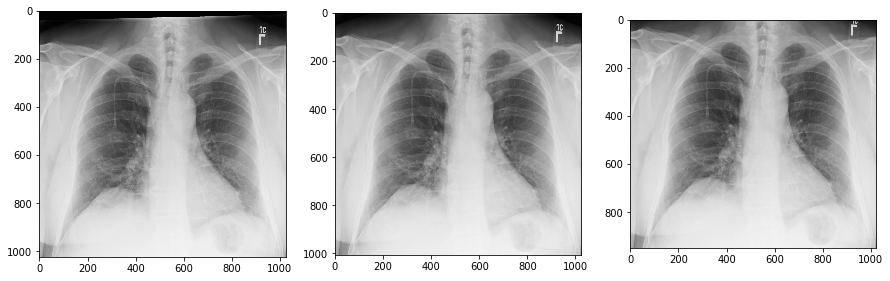

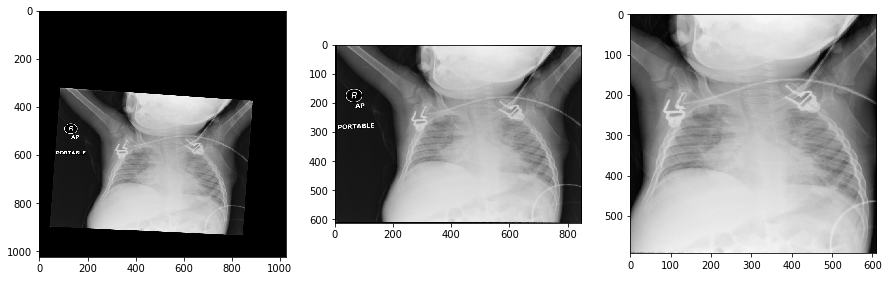

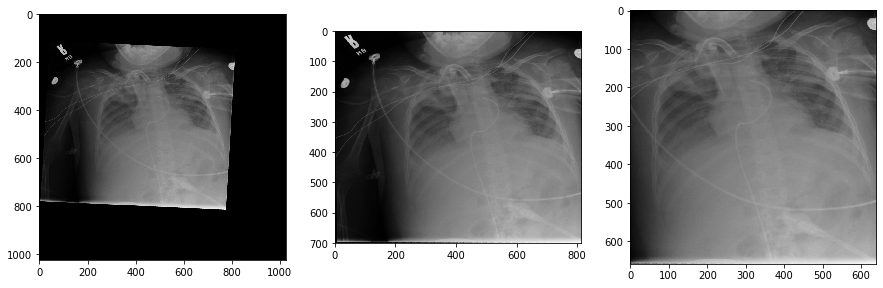

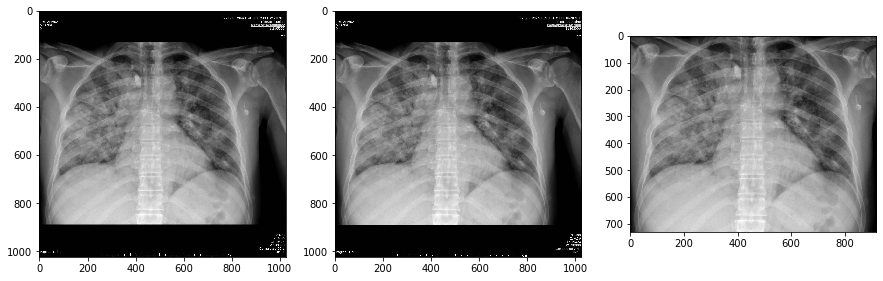

In [22]:
for path in paths:
    original = load_image(path)
    image = perspective_correction(original)
    bboxed = blur_bbox(image)
    
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    axes[0].imshow(original, cmap="gray")
    axes[1].imshow(image, cmap="gray")
    axes[2].imshow(bboxed, cmap="gray")
    plt.show()